In [1]:
#import the necessary dependencies
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from glob import glob

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf



# Load dataset directory
data_dir = r'G:\projects\cricket shot detection\archive\data'

# List the folders present in the given path
class_names = os.listdir(data_dir)
class_names


['drive', 'legglance-flick', 'pullshot', 'sweep']

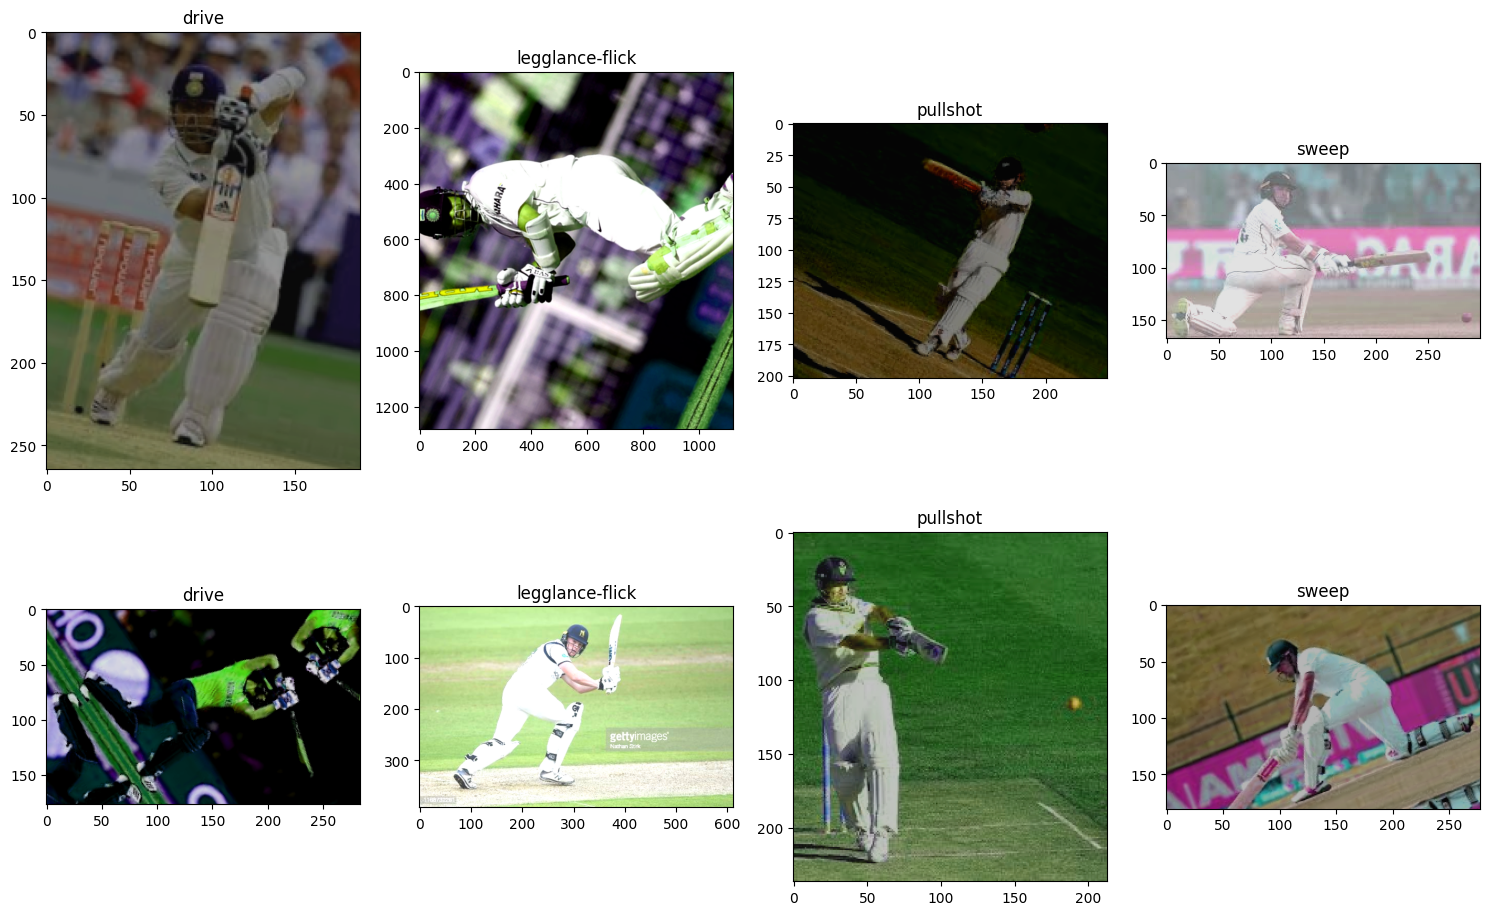

In [2]:
def visualize_images(image_paths: List[str]):
    max_rows = 2
    max_cols = 4
    fig, axs = plt.subplots(max_rows, max_cols, figsize=(15, 10))
    idx = 0
    for col in range(max_cols):
        for row in range(max_rows):
            if idx < len(image_paths):  # Check if idx is within bounds
                img = cv2.imread(image_paths[idx])
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                class_name = image_paths[idx].split(os.path.sep)[-2]  # Use os.path.sep for compatibility
                axs[row, col].imshow(image)
                axs[row, col].set_title(class_name)
            else:
                axs[row, col].axis('off')  # Hide unused subplots
            idx += 1
    plt.tight_layout()
    plt.show()

# Collect two random image paths from each class
image_paths = []
for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    all_images = glob(class_folder + '/*.png')
    if len(all_images) >= 2:  # Ensure there are at least 2 images in each class
        paths = random.sample(all_images, k=2)
        image_paths.extend(paths)

visualize_images(image_paths)


In [3]:
# Create dataframe with image paths and labels
image_paths = []
class_labels = []
for class_name in class_names:
    paths = glob(os.path.join(data_dir, class_name) + '/' + "*.png")
    image_paths.extend(paths)
    class_labels.extend([class_name]*len(paths))

df = pd.DataFrame(data={'image_path': image_paths, 'label': class_labels})

# Data split for train, validation, and test sets
X = df
y = df[['label']]

df_train, df_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.30, random_state=40)
df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=40)


In [4]:
BATCH_SIZE = 32
IMG_SHAPE_2 = (224, 224, 3)
num_classes = 4

train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)

valid_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)


Found 3210 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.


In [5]:
# Define the SENet model (you can load a pre-built model from TensorFlow Hub if needed)
senet = tf.keras.applications.ResNet50(  # Placeholder for SENet model (not in Keras directly)
    include_top=False,
    input_shape=IMG_SHAPE_2,
    weights='imagenet'
)
senet.trainable = False

# Add input and output layers
input_layer = tf.keras.layers.Input(shape=IMG_SHAPE_2)
x = senet(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_senet = tf.keras.Model(inputs=[input_layer], outputs=[output])


In [6]:
from tensorflow.keras.optimizers import Adam  # Use Adam directly from tf.keras.optimizers

# Compile the model
model_senet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

# Train the model
history_senet = model_senet.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/10


101/101 [==============================] - 155s 2s/step - loss: 1.3344 - accuracy: 0.6433 - val_loss: 0.4452 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 141s 1s/step - loss: 0.4179 - accuracy: 0.8455 - val_loss: 0.2613 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - 141s 1s/step - loss: 0.2902 - accuracy: 0.8938 - val_loss: 0.2879 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 4/10
101/101 [==============================] - 140s 1s/step - loss: 0.1828 - accuracy: 0.9377 - val_loss: 0.1610 - val_accuracy: 0.9564 - lr: 0.0010
Epoch 5/10
101/101 [==============================] - 149s 1s/step - loss: 0.1651 - accuracy: 0.9436 - val_loss: 0.1438 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 6/10
101/101 [==============================] - 146s 1s/step - loss: 0.1392 - accuracy: 0.9526 - val_loss: 0.1840 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 7/10
101/101 [==============================] - 143s 1s/

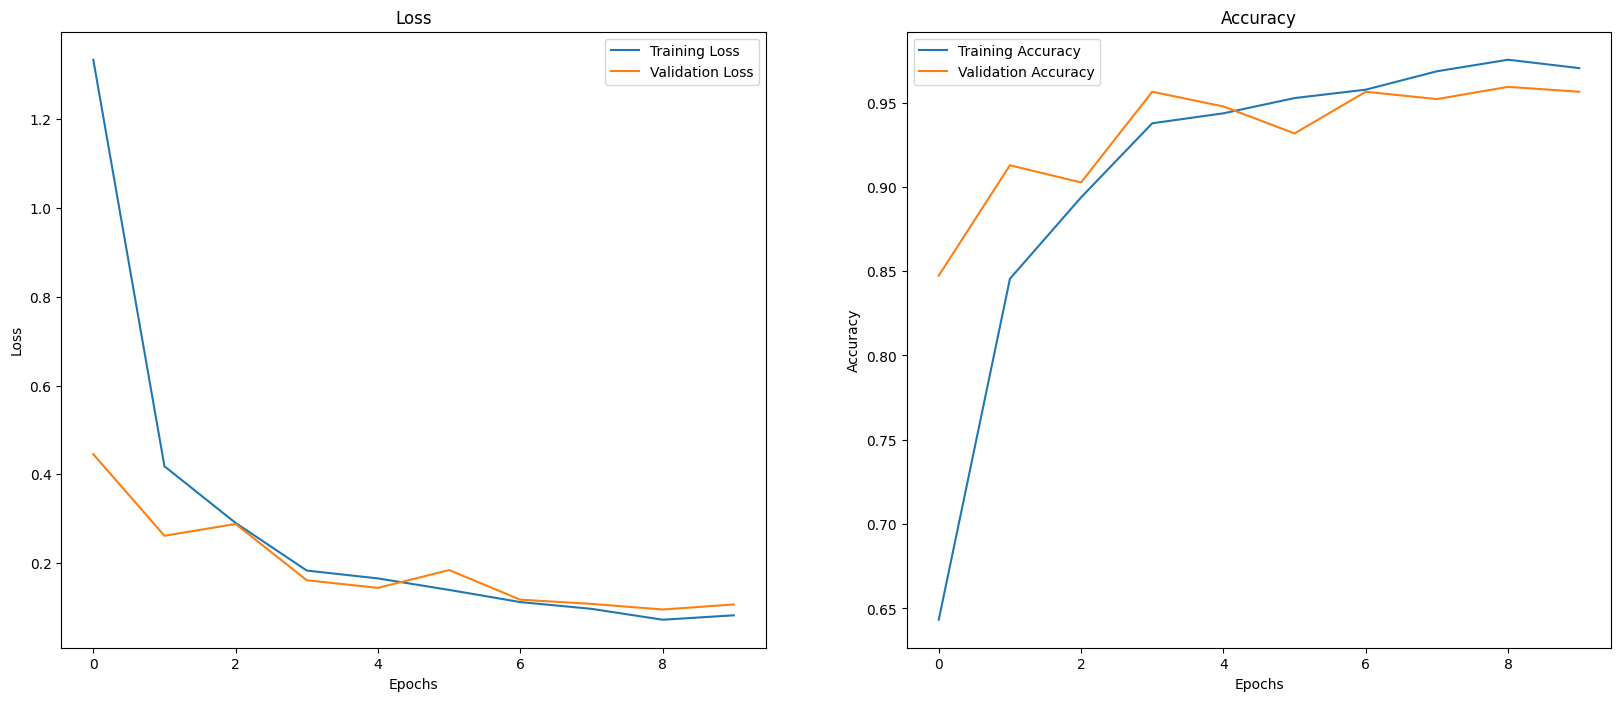

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(tr_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot the training results
plot_training(history_senet)


In [8]:
import itertools
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

# Define the hyperparameter values to use
learning_rates = [ 0.0001]
batch_sizes = [16]
dropout_rates = [0.2, 0.3, 0.4]

# Store results for each combination
results = []

# Prepare callback settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001, verbose=1)

# Iterate over all combinations of hyperparameters
for lr, batch_size, dropout_rate in itertools.product(learning_rates, batch_sizes, dropout_rates):
    print(f"\nTesting combination: Learning rate={lr}, Batch size={batch_size}, Dropout={dropout_rate}")

    # Re-initialize model to ensure a fresh start
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')(input_layer)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    # Compile with selected learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Track epochs to identify overfitting point
    early_stopping_triggered = False
    history = {'epoch': [], 'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(1, 11):  # Run for a max of 10 epochs
        print(f"Epoch {epoch}/{10}")

        # Train the model for one epoch
        hist = model.fit(
            train_generator,
            epochs=1,
            validation_data=valid_generator,
            batch_size=batch_size,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Record accuracy and loss
        train_acc = hist.history['accuracy'][0]
        val_acc = hist.history['val_accuracy'][0]
        train_loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]

        # Append to history
        history['epoch'].append(epoch)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Check for overfitting condition
        if epoch > 2 and val_loss > history['val_loss'][-2] and not early_stopping_triggered:
            print(f"Overfitting detected at epoch {epoch}")
            early_stopping_triggered = True
            break

    # Store results for the current hyperparameter combination
    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'epochs_run': len(history['epoch']),
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1]
    })

# Print all results for each combination
print("\nResults Summary:")
for result in results:
    print(f"\nCombination: Learning Rate={result['learning_rate']}, Batch Size={result['batch_size']}, Dropout Rate={result['dropout_rate']}")
    print(f"  Epochs Run: {result['epochs_run']}")
    print(f"  Final Training Accuracy: {result['final_train_acc']:.4f}")
    print(f"  Final Validation Accuracy: {result['final_val_acc']:.4f}")
    print(f"  Final Training Loss: {result['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {result['final_val_loss']:.4f}")



Testing combination: Learning rate=0.0001, Batch size=16, Dropout=0.2
Epoch 1/10
101/101 [==============================] - 482s 5s/step - loss: 1.1182 - accuracy: 0.7969 - val_loss: 0.2954 - val_accuracy: 0.9186 - lr: 1.0000e-04
Epoch 2/10
101/101 [==============================] - 465s 5s/step - loss: 0.0880 - accuracy: 0.9676 - val_loss: 0.1088 - val_accuracy: 0.9695 - lr: 1.0000e-04
Epoch 3/10
101/101 [==============================] - 468s 5s/step - loss: 0.0667 - accuracy: 0.9819 - val_loss: 0.0592 - val_accuracy: 0.9797 - lr: 1.0000e-04
Epoch 4/10
101/101 [==============================] - 466s 5s/step - loss: 0.0539 - accuracy: 0.9810 - val_loss: 1.9378 - val_accuracy: 0.7398 - lr: 1.0000e-04
Overfitting detected at epoch 4

Testing combination: Learning rate=0.0001, Batch size=16, Dropout=0.3
Epoch 1/10
101/101 [==============================] - 482s 5s/step - loss: 1.2938 - accuracy: 0.7907 - val_loss: 0.1498 - val_accuracy: 0.9346 - lr: 1.0000e-04
Epoch 2/10
101/101 [======

In [6]:
import itertools
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

# Define the hyperparameter values to use
learning_rates = [ 0.001, 0.01]
batch_sizes = [16]
dropout_rates = [0.2, 0.3, 0.4]

# Store results for each combination
results = []

# Prepare callback settings
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.000001, verbose=1)

# Iterate over all combinations of hyperparameters
for lr, batch_size, dropout_rate in itertools.product(learning_rates, batch_sizes, dropout_rates):
    print(f"\nTesting combination: Learning rate={lr}, Batch size={batch_size}, Dropout={dropout_rate}")

    # Re-initialize model to ensure a fresh start
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')(input_layer)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output])

    # Compile with selected learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Track epochs to identify overfitting point
    early_stopping_triggered = False
    history = {'epoch': [], 'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(1, 11):  # Run for a max of 10 epochs
        print(f"Epoch {epoch}/{10}")

        # Train the model for one epoch
        hist = model.fit(
            train_generator,
            epochs=1,
            validation_data=valid_generator,
            batch_size=batch_size,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Record accuracy and loss
        train_acc = hist.history['accuracy'][0]
        val_acc = hist.history['val_accuracy'][0]
        train_loss = hist.history['loss'][0]
        val_loss = hist.history['val_loss'][0]

        # Append to history
        history['epoch'].append(epoch)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Check for overfitting condition
        if epoch > 2 and val_loss > history['val_loss'][-2] and not early_stopping_triggered:
            print(f"Overfitting detected at epoch {epoch}")
            early_stopping_triggered = True
            break

    # Store results for the current hyperparameter combination
    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'epochs_run': len(history['epoch']),
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1]
    })

# Print all results for each combination
print("\nResults Summary:")
for result in results:
    print(f"\nCombination: Learning Rate={result['learning_rate']}, Batch Size={result['batch_size']}, Dropout Rate={result['dropout_rate']}")
    print(f"  Epochs Run: {result['epochs_run']}")
    print(f"  Final Training Accuracy: {result['final_train_acc']:.4f}")
    print(f"  Final Validation Accuracy: {result['final_val_acc']:.4f}")
    print(f"  Final Training Loss: {result['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {result['final_val_loss']:.4f}")



Testing combination: Learning rate=0.001, Batch size=16, Dropout=0.2
Epoch 1/10


101/101 [==============================] - 446s 4s/step - loss: 5.3596 - accuracy: 0.4589 - val_loss: 39.1155 - val_accuracy: 0.4201 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 418s 4s/step - loss: 0.8517 - accuracy: 0.6885 - val_loss: 0.9892 - val_accuracy: 0.6962 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - 417s 4s/step - loss: 0.5172 - accuracy: 0.8280 - val_loss: 2.2400 - val_accuracy: 0.5959 - lr: 0.0010
Overfitting detected at epoch 3

Testing combination: Learning rate=0.001, Batch size=16, Dropout=0.3
Epoch 1/10
101/101 [==============================] - 434s 4s/step - loss: 5.8617 - accuracy: 0.4455 - val_loss: 2.1533 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 421s 4s/step - loss: 0.8138 - accuracy: 0.6935 - val_loss: 1.1326 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 3/10
101/101 [=========================